In [39]:
#importing important libraries
%matplotlib inline
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import statsmodels.api as sm  
import seaborn as sb  
sb.set_style('darkgrid')
from datetime import datetime
from dateutil.parser import parse
from pandas.core import datetools
stock_data =pd.read_csv('F:/timeseries/historical_data.csv')
stock_data.head()


,symbol,date_txn,open,low,high,close_price,volume,lead_1,lead_5,lead_10,name,class_type_of
0,SPY,11/10/2015,207.51,207.19,208.60,208.55,71844000,207.67,205.47,209.35,SPDR S&P500,S_P_500
1,SPY,11/11/2015,208.88,207.66,208.94,207.67,67251000,204.84,208.73,209.32,SPDR S&P500,S_P_500
2,SPY,11/12/2015,206.50,204.82,207.06,204.84,118209400,202.54,208.55,209.56,SPDR S&P500,S_P_500
3,SPY,11/13/2015,204.35,202.44,204.67,202.54,145494400,205.62,209.31,208.69,SPDR S&P500,S_P_500
4,SPY,11/16/2015,202.32,202.18,205.69,205.62,112996000,205.47,209.07,210.68,SPDR S&P500,S_P_500


In [40]:
#checking the data types
stock_data.dtypes

symbol            object
date_txn          object
open             float64
low              float64
high             float64
close_price      float64
volume             int64
lead_1           float64
lead_5           float64
lead_10          float64
name              object
class_type_of     object
dtype: object

In [41]:
#converting object data type of date_txn to datetime64[ns]
stock_data['date_txn']=pd.to_datetime(stock_data['date_txn'],format='%m/%d/%Y')


In [42]:
#taking date_txn as the index
stock_data= stock_data.set_index('date_txn')

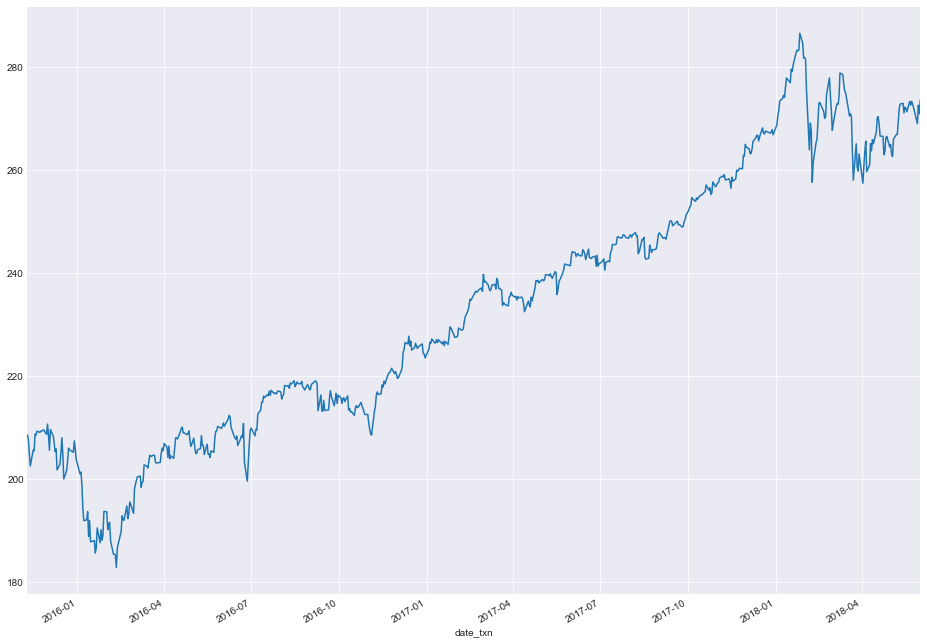

In [43]:
stock_data['close_price'].plot(figsize=(16, 12))  
#plotting the graph to check for stationarity

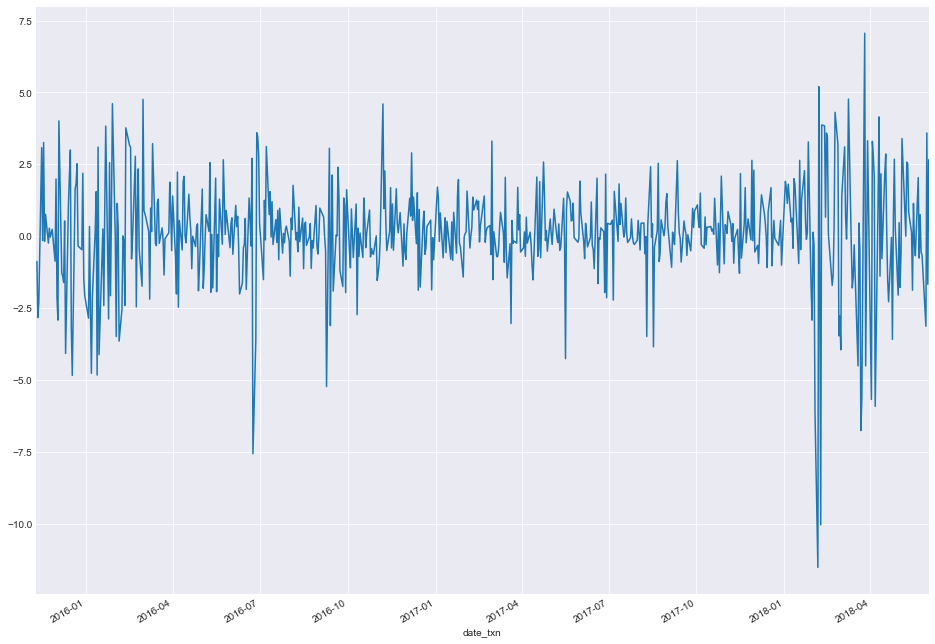

In [44]:
# The first thing we can try is a first difference of the series.
#In other words, subtract the previous value t-1 from the current value t to get the difference d(t).
stock_data['First Difference'] = stock_data['close_price'] - stock_data['close_price'].shift()  
stock_data['First Difference'].plot(figsize=(16, 12))  
#The data no longer appears to be trending up over time and is instead centered around 0

E:\anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=True).var()
  


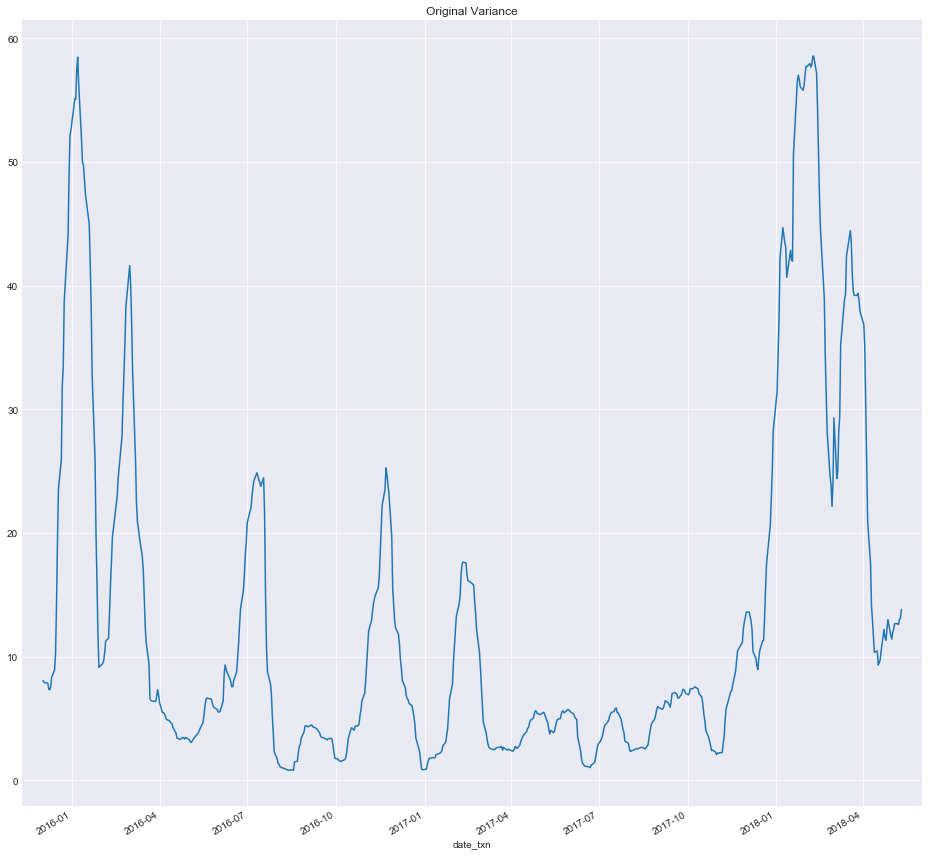

In [45]:
#printing out the rolling variance of the time series
stock_data['Original Variance'] = pd.rolling_var(stock_data['close_price'], 30, min_periods=None, freq=None, center=True)  
fig, ax = plt.subplots(1, 1, figsize=(13, 12))  
stock_data['Original Variance'].plot( title='Original Variance')  
fig.tight_layout()  
#changes in the value are clearly visible throughout the entire data set
#seeing the distribution the series is stationary

In [46]:
#let's create some lag variables y(t-1), y(t-2) etc. and examine their relationship to y(t). 
#We'll look at 1 and 2-day lags along with weekly and monthly lags to look for "seasonal" effects.
stock_data['Lag 1'] = stock_data['First Difference'].shift()  
stock_data['Lag 2'] = stock_data['First Difference'].shift(2)  
stock_data['Lag 5'] = stock_data['First Difference'].shift(5)  
stock_data['Lag 30'] = stock_data['First Difference'].shift(30)  

In [47]:
#usage of acf and pacf to check for correlation
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(stock_data['First Difference'].iloc[1:])  
lag_partial_correlations = pacf(stock_data['First Difference'].iloc[1:])  

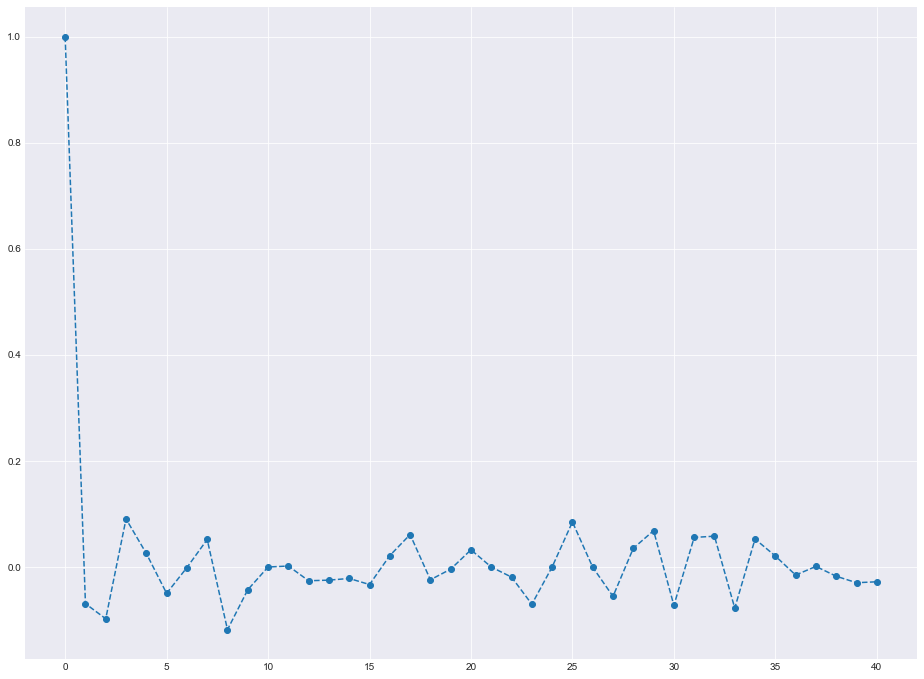

In [48]:
#plotting of acf
fig, ax = plt.subplots(figsize=(16,12))  
ax.plot(lag_correlations, marker='o', linestyle='--')  
# What this shows is that there is no significant (> 0.2) correlation between the value at time t and at any time prior to t. 
#In order words, the series is a random walk. 

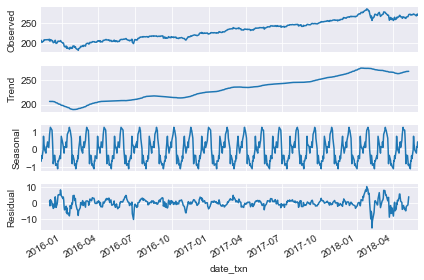

In [49]:
#Another interesting technique we can try is a decomposition. 
#This technique attempts to break down a time series into trend, seasonal, and residual factors
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(stock_data['close_price'], model='additive', freq=30)  
fig = plt.figure()  
fig = decomposition.plot()  

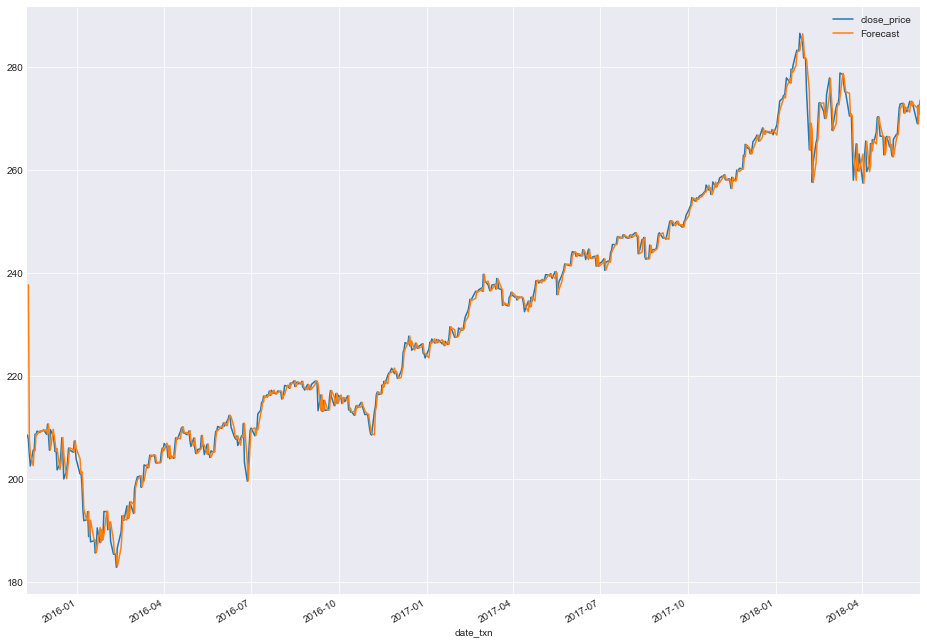

In [50]:
#Let's start with a simple moving average model.
#as the forecasts are really close to original we need furthur investigation
model = sm.tsa.ARIMA(stock_data['close_price'].iloc[1:], order=(1, 0, 0))  
results = model.fit(disp=-1)  
stock_data['Forecast'] = results.fittedvalues  
stock_data[['close_price', 'Forecast']].plot(figsize=(16, 12))  

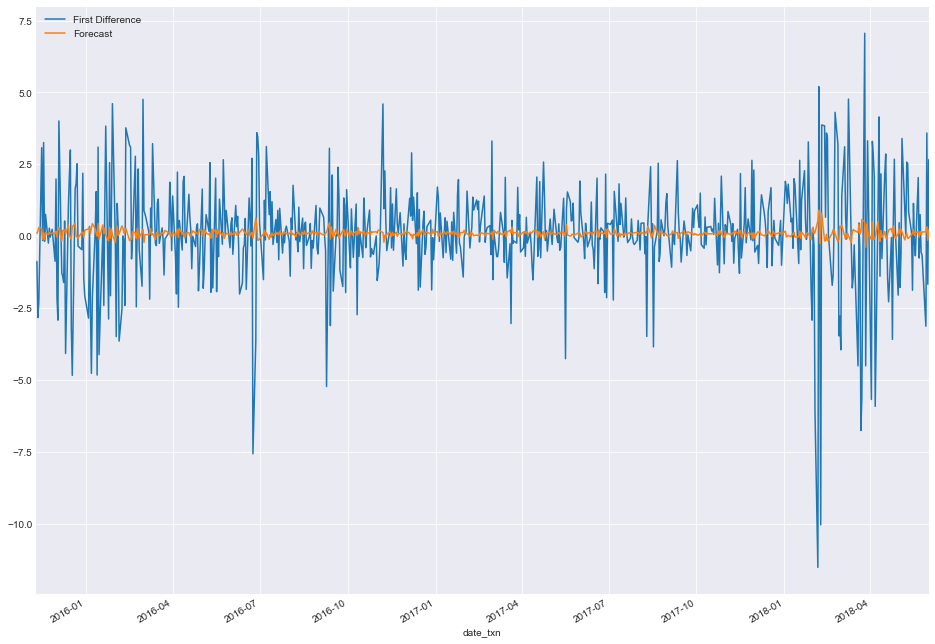

In [51]:
#for better prediction we have now used the differenced series
# We conclude that our forecasted changes are generally much smaller than the actual changes
model = sm.tsa.ARIMA(stock_data['First Difference'].iloc[1:], order=(1, 0, 0))  
results = model.fit(disp=-1)  
stock_data['Forecast'] = results.fittedvalues  
stock_data[['First Difference', 'Forecast']].plot(figsize=(16, 12))  

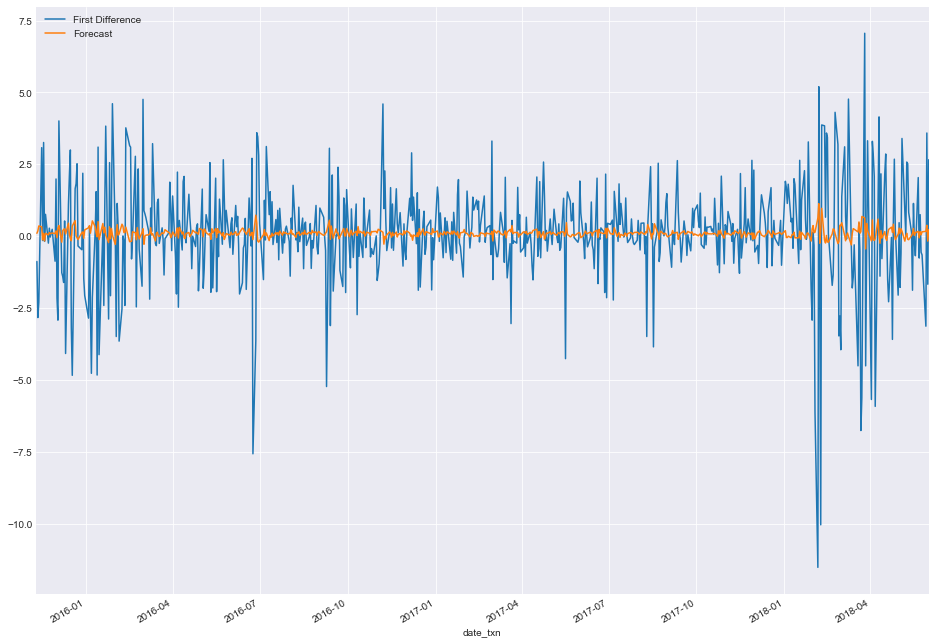

In [53]:
#Exponential smoothing spreads out the impact of previous values using an exponential weighting
#This results in better prediction
#Hence we have used it 
 
model = sm.tsa.ARIMA(stock_data['First Difference'].iloc[1:], order=(0, 0, 1))  
results = model.fit(disp=-1)  
stock_data['Forecast'] = results.fittedvalues  
stock_data[['First Difference', 'Forecast']].plot(figsize=(16, 12))  